# Mask R-CNN

This notebook shows how to train a Mask R-CNN object detection and segementation model on a custom coco-style data set.

In [3]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# sys.path.insert(0, '../')

from mrcnn.config import Config
import mrcnn.utils as utils
import mrcnn.model as modellib
import mrcnn.visualize as visualize
from mrcnn.model import log
import mcoco.coco as coco
import mextra.utils as extra_utils
import keras
%matplotlib inline
%config IPCompleter.greedy=True
import warnings
warnings.filterwarnings('ignore')


In [4]:
HOME_DIR = '.'
DATA_DIR = os.path.join(HOME_DIR, "pycococreator/train")
MODEL_DIR = os.path.join(DATA_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(HOME_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Dataset

Organize the dataset using the following structure:

```
DATA_DIR
│
└───annotations
│   │   instances_<subset><year>.json
│   
└───<subset><year>
    │   image021.jpeg
    │   image022.jpeg
```

In [6]:
dataset_train = coco.CocoDataset()
dataset_train.load_coco(DATA_DIR, subset="plants_train", year="2019")
dataset_train.prepare()

dataset_validate = coco.CocoDataset()
dataset_validate.load_coco(DATA_DIR, subset="plants_validate", year="2019")
dataset_validate.prepare()

# dataset_test = coco.CocoDataset()
# dataset_test.load_coco(DATA_DIR, subset="shapes_test", year="2018")
# dataset_test.prepare()

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


[43 48 11 36]
(400, 600, 5)
(400, 600, 5)
(array([False]), array([240000]))


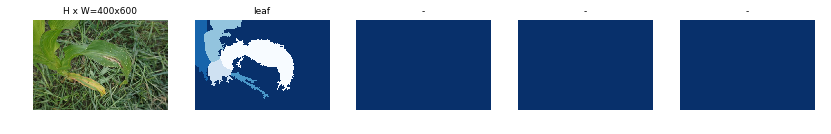

(400, 600, 7)
(400, 600, 7)
(array([False]), array([240000]))


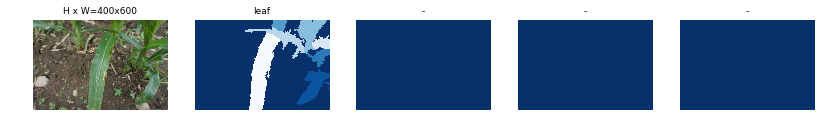

(400, 600, 3)
(400, 600, 3)
(array([False,  True]), array([237024,   2976]))


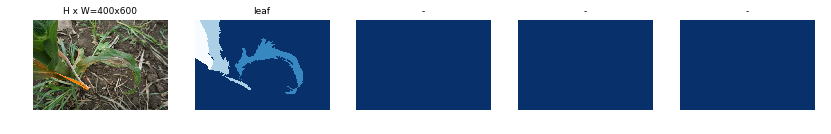

(400, 600, 7)
(400, 600, 7)
(array([False]), array([240000]))


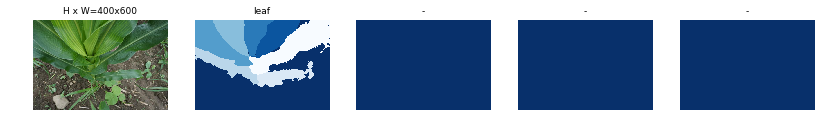

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
print(image_ids)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, mask2, class_ids = dataset_train.load_mask(image_id)
    print(mask.shape)
    print(mask2.shape)
    print(np.unique(mask2[:,:,0], return_counts=True))
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Configuration

In [8]:
image_size = 128
rpn_anchor_template = (1, 2, 4, 8, 16) # anchor sizes in pixels
rpn_anchor_scales = tuple(i * (image_size // 16) for i in rpn_anchor_template)

class ShapesConfig(Config):
    """Configuration for training on the shapes dataset.
    """
    NAME = "shapes"

    # Train on 1 GPU and 2 images per GPU. Put multiple images on each
    # GPU if the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes (triangles, circles, and squares)

    # Use smaller images for faster training. 
    IMAGE_MAX_DIM = image_size
    IMAGE_MIN_DIM = image_size
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = rpn_anchor_scales

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

#     STEPS_PER_EPOCH = 400
    STEPS_PER_EPOCH = 10

    VALIDATION_STEPS = 2
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 16
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

# Model


In [11]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [12]:
inititalize_weights_with = "coco"  # imagenet, coco, or last

if inititalize_weights_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
    
elif inititalize_weights_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
     
elif inititalize_weights_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)
# model.load_weights(MODEL_PATH2, by_name=True)

In [13]:
import imgaug
augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
                ])


# Training

Training in two stages

## Heads

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

## Fine-tuning

Fine-tune all layers. Pass layers="all to train all layers.

In [ ]:
# 1000, 200
model.train(dataset_train, dataset_validate, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1,
            layers='heads', augmentation=augmentation)

model.train(dataset_train, dataset_validate, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=3, # starts from the previous epoch, so only 1 additional is trained 
            layers="all",augmentation=augmentation)



Starting at epoch 0. LR=0.001

Checkpoint Path: ./pycococreator/train/logs/shapes20200629T1637/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask2_conv1      (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask2_bn1        (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask2_conv2      (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_mask2_bn2        (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask

Epoch 2/3


# Detection

In [9]:
image_size=128
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MAX_DIM = image_size
    IMAGE_MIN_DIM = image_size

class InferenceConfig2(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MAX_DIM = 384
    IMAGE_MIN_DIM = 384

inference_config = InferenceConfig()
inference_config2 = InferenceConfig2()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
print(model.find_last())








Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
./pycococreator/train/logs/shapes20200707T0038/mask_rcnn_shapes_0099.h5


In [49]:
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights('./pycococreator/train/logs/mask_rcnn_shapes_0142.h5', by_name=True)
# model.load_weights('./pycococreator/train/logs/shapes20200707T0038/mask_rcnn_shapes_0040.h5', by_name=True)


Loading weights from  ./pycococreator/train/logs/shapes20200707T0038/mask_rcnn_shapes_0099.h5


### Test on a random image from the test set

First, show the ground truth of the image, then show detection results.

(384, 384, 6)
(384, 384, 6)


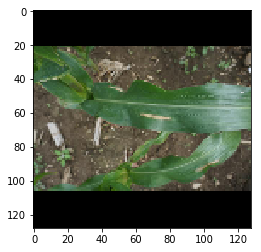

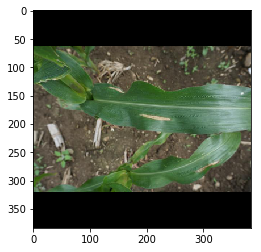

In [50]:
import scipy, skimage
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_mask2 =\
    modellib.load_image_gt(dataset_train, inference_config, image_id, use_mini_mask=False)

original_image_2, image_meta_2, gt_class_id_2, gt_bbox_2, gt_mask_2, gt_mask2_2 =\
    modellib.load_image_gt(dataset_train, inference_config2, image_id, use_mini_mask=False)

resized_mask=skimage.transform.resize(gt_mask,(384,384),order=0)
resized_mask2=skimage.transform.resize(gt_mask2,(384,384),order=0)
print(resized_mask.shape)
print(resized_mask2.shape)

plt.imshow(original_image)
plt.show()
plt.imshow(original_image_2)
plt.show()

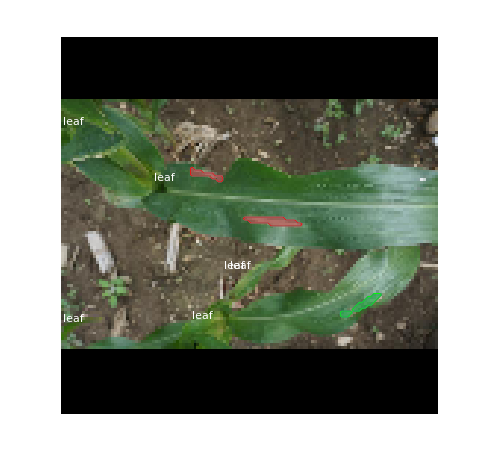

In [51]:
visualize.display_instances(original_image, gt_bbox, gt_mask2, gt_mask2, gt_class_id, 
                            dataset_validate.class_names, figsize=(8, 8),show_mask=True, show_mask2=True, show_bbox=False)



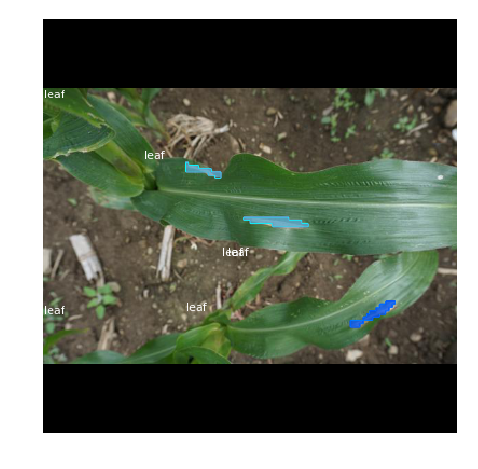

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  240.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  136.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


In [52]:
visualize.display_instances(original_image_2, gt_bbox*3, resized_mask2, resized_mask2, gt_class_id, 
                            dataset_validate.class_names, figsize=(8, 8),show_mask=True, show_mask2=True, show_bbox=False)

results = model.detect([original_image], verbose=1)

r = results[0]


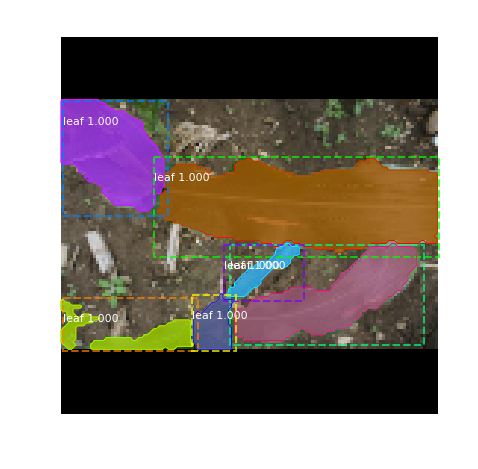

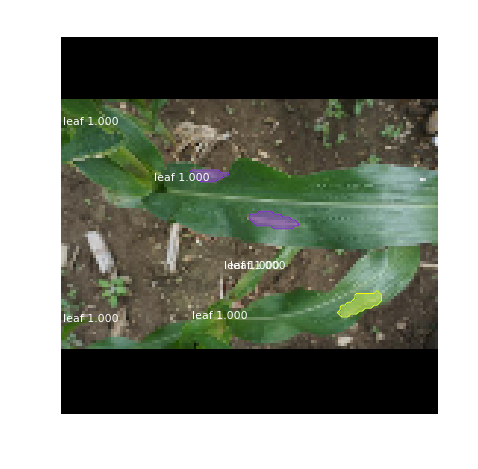

In [53]:
visualize.display_instances(original_image, r['rois'], r['masks'], r['masks'], r['class_ids'], 
                            dataset_validate.class_names, r['scores'], ax=get_ax(),show_mask=True, show_mask2=True, show_bbox=True)

visualize.display_instances(original_image, r['rois'], r['masks2'], r['masks2'], r['class_ids'], 
                            dataset_validate.class_names, r['scores'], ax=get_ax(),show_mask=True, show_mask2=True, show_bbox=False)

In [59]:
len(dataset_train.image_ids)
os.makedirs('results')

In [60]:
from PIL import Image
for i in range(len(dataset_train.image_ids)):
    image_id = dataset_train.image_ids[i]
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_mask2 =\
    modellib.load_image_gt(dataset_train, inference_config, image_id, use_mini_mask=False)
    
    results = model.detect([original_image], verbose=0)
    r = results[0]
    
    original_image_2, image_meta_2, gt_class_id_2, gt_bbox_2, gt_mask_2, gt_mask2_2 =\
        modellib.load_image_gt(dataset_train, inference_config2, image_id, use_mini_mask=False)

    resized_mask=skimage.transform.resize(r['masks'],(384,384),order=1)
    resized_mask2=skimage.transform.resize(r['masks2'],(384,384),order=1)
    
    save_name='results/Original_imageid-'+ str(image_id) + '.png'
    save_name1='results/gt_mask_imageid-'+ str(image_id) + '.png'
    save_name2='results/gt_mask_v2_imageid-'+ str(image_id) + '.png'
    save_name3='results/gt_mask2_imageid-'+ str(image_id) + '.png'
    save_name4='results/gt_mask2_v2_imageid-'+ str(image_id) + '.png'
    save_name5='results/pred_mask_imageid-'+ str(image_id) + '.png'
    save_name8='results/pred_mask_label_imageid-'+ str(image_id) + '.png'
    save_name6='results/pred_mask2_imageid-'+ str(image_id) + '.png'
    save_name7='results/pred_mask2_v2_imageid-'+ str(image_id) + '.png'
    
    
#     visualize.display_instances(original_image_2, gt_bbox_2, gt_mask_2, gt_mask_2, gt_class_id_2, 
#                             dataset_validate.class_names, figsize=(8, 8),show_mask=True, show_mask2=True, show_bbox=False,save_name=save_name1)
    
#     visualize.display_instances(original_image_2, r['rois']*3, resized_mask, resized_mask, r['class_ids'], 
#                             dataset_validate.class_names, r['scores'], ax=get_ax(),show_mask=True, show_mask2=True, show_bbox=True,save_name=save_name5)
    
#     Image.fromarray(original_image_2).save(save_name)
    
    h,w,l=gt_mask_2.shape
    Mask=np.zeros((h,w)).astype('uint8')
    for j in range(l):
        mask=gt_mask_2[:,:,j].astype('bool')
        Mask[mask]=j+1
    Image.fromarray(Mask).save(save_name2)




#     h,w,l=resized_mask.shape
#     Mask=np.zeros((h,w)).astype('uint8')
#     for j in range(l):
#         mask=resized_mask[:,:,j].astype('bool')
#         Mask[mask]=j+1
#     Image.fromarray(Mask).save(save_name8)




#     h,w,l=gt_mask2_2.shape
#     Mask=np.zeros((h,w),'uint8')
#     for j in range(l):
#         mask=gt_mask2_2[:,:,j]
#         Mask[mask]=j+1
#     _,ax=plt.subplots(1, figsize=(8,8))
#     plt.imshow(Mask)
#     plt.savefig(save_name3)
#     plt.show()
    
#     h,w,l=gt_mask2_2.shape
#     Mask=np.zeros((h,w)).astype('bool')
#     for j in range(l):
#         mask=gt_mask2_2[:,:,j]
#         Mask[mask]=1
#     Image.fromarray(Mask.astype(np.uint8)*255).convert('1').save(save_name4)

    
#     h,w,l=resized_mask2.shape
#     Mask=np.zeros((h,w),'uint8')
#     for j in range(l):
#         mask=resized_mask2[:,:,j].astype('bool')
#         Mask[mask]=j+1
#     _,ax=plt.subplots(1, figsize=(8,8))
#     plt.imshow(Mask)
#     plt.savefig(save_name6)
#     plt.show()
    
#     h,w,l=resized_mask2.shape
#     Mask=np.zeros((h,w)).astype('bool')
#     for j in range(l):
#         mask=resized_mask2[:,:,j].astype('bool')
#         Mask[mask]=1
#     Image.fromarray(Mask.astype(np.uint8)*255).convert('1').save(save_name7)
#     break;

In [24]:
np.unique(resized_mask2[:,:,0])

array([0., 1.])

51185


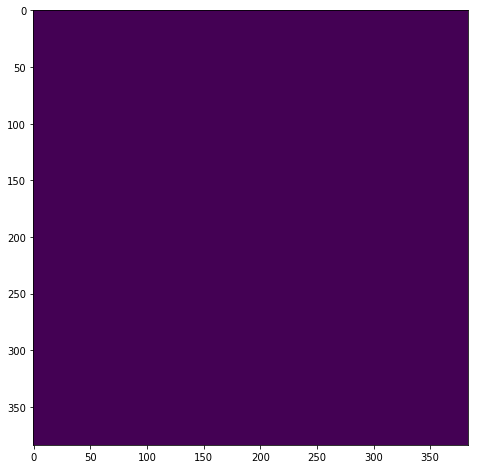

In [20]:
h,w,l=gt_mask_2.shape
Mask=np.zeros((h,w),'uint8')
for j in range(l):
    mask=gt_mask_2[:,:,j]
    print(np.sum(mask))
    Mask[mask]=j
_,ax=plt.subplots(1, figsize=(8,8))
plt.imshow(Mask)
plt.savefig(save_name2)
# plt.show()

[False  True]


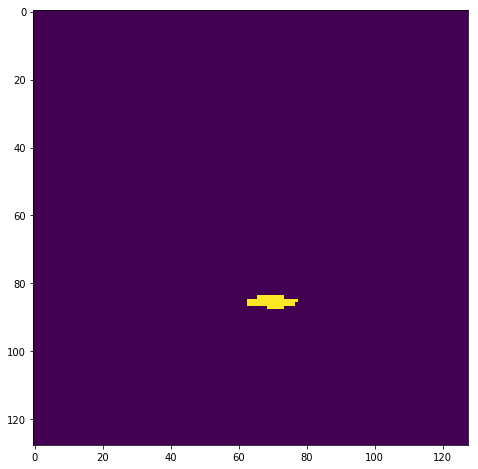

In [102]:
h,w,l=r['masks'].shape
Mask=np.zeros((h,w)).astype('bool')
for j in range(l):
    mask=r['masks2'][:,:,j]
    Mask[mask]=1
_,ax=plt.subplots(1, figsize=(8,8))
print(np.unique(Mask))
plt.imshow(Mask)

# Evaluation

Use the test dataset to evaluate the precision of the model on each class. 

In [43]:
predictions =\
extra_utils.compute_multiple_per_class_precision(model, inference_config, dataset_train,
                                                 number_of_images=500, iou_threshold=0.5)
complete_predictions = []

for shape in predictions:
    complete_predictions += predictions[shape]
    print("{} ({}): {}".format(shape, len(predictions[shape]), np.mean(predictions[shape])))

print("--------")
print("average: {}".format(np.mean(complete_predictions)))

leaf (500): 0.7393854729830482
--------
average: 0.7393854729830482


## Convert result to COCO

Converting the result back to a COCO-style format for further processing 

In [87]:
import json
import pylab
import matplotlib.pyplot as plt
from tempfile import NamedTemporaryFile
from pycocotools.coco import COCO

coco_dict = extra_utils.result_to_coco(results[0], dataset_validate.class_names,
                                       np.shape(original_image)[0:2], tolerance=0)

with NamedTemporaryFile('w') as jsonfile:
    json.dump(coco_dict, jsonfile)
    jsonfile.flush()
    coco_data = COCO(jsonfile.name)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


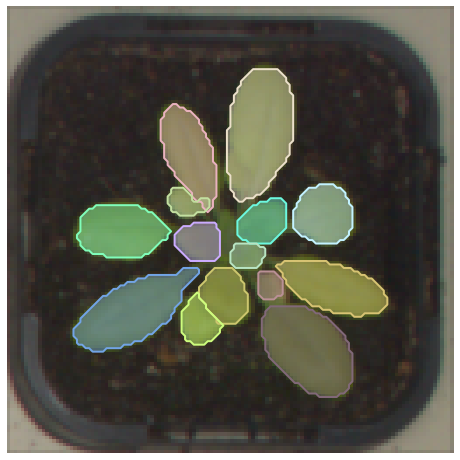

In [93]:
category_ids = coco_data.getCatIds(catNms=['square', 'circle', 'triangle'])
image_data = coco_data.loadImgs(1)[0]
image = original_image
plt.imshow(image); plt.axis('off')
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
annotation_ids = coco_data.getAnnIds(imgIds=image_data['id'], catIds=category_ids, iscrowd=None)
annotations = coco_data.loadAnns(annotation_ids)
coco_data.showAnns(annotations)

original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  349.00000  float64
gt_class_id              shape: (6,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (6, 4)                min:    0.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 6)         min:    0.00000  max:    1.00000  bool


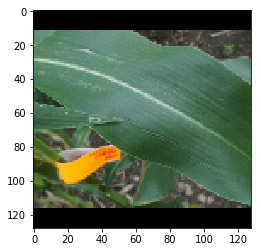

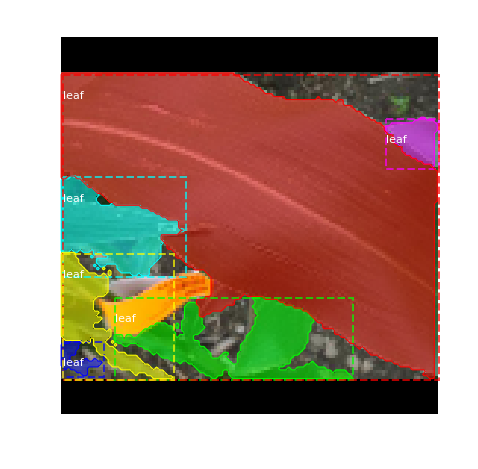

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


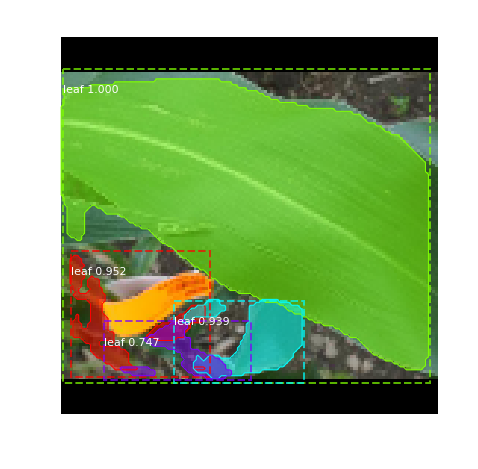

In [68]:
image_id = random.choice(dataset_validate.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_validate, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
plt.imshow(original_image)
plt.show()
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_validate.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
# print(r['masks'][0])
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_validate.class_names, r['scores'], ax=get_ax())